In [13]:
import sys
!{sys.executable} -m pip install statsmodels


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [14]:
import sklearn
sklearn.__version__

'1.3.0'

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as stt
from statsmodels import tsa
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import os

warnings.filterwarnings("ignore")

def is_stationary(df, maxlag=52, autolag=None, regression='ct'):
    """
    Check if a time series is stationary using the Augmented Dickey-Fuller Test.

    Parameters:
        df (pandas.Series): The time series data as a pandas Series.
        maxlag (int): The maximum lag order to consider for the test.
        autolag (str or None): Method to choose the lag order automatically.
        regression (str): The type of regression used in the test.

    Returns:
        bool: True if the time series is stationary, False otherwise.
    """
    # Perform the Augmented Dickey-Fuller Test on the time series data
    adf_test = stt.adfuller(df.values, maxlag=maxlag, autolag=autolag, regression=regression)

    # Extract the test statistic (ADF statistic) and the critical value for 5% significance level
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]

    # Check if the ADF statistic is less than the critical value for 5% significance level
    # If True, the time series is stationary; otherwise, it is non-stationary
    result = adf < cv_5

    return result


def d_param(df, max_lag=52):
    """
    Find the differencing order (d) required to make a non-stationary time series stationary.

    Parameters:
        df (pandas.Series): The time series data as a pandas Series.
        max_lag (int): The maximum lag order to consider when finding the differencing order.

    Returns:
        int: The differencing order (d) required to make the time series stationary.
    """
    # Initialize the differencing order (d) to 0
    d = 0

    # Check if the input time series is non-stationary using the is_stationary function
    if not is_stationary(df):
        # If the time series is non-stationary, try increasing the differencing order (d)
        # until a stationary time series is found
        for i in range(1, max_lag):
            if is_stationary(df.diff(i).dropna()):
                d = i
                break;

    return d

filePath = os.path.join(os.path.dirname(os.getcwd()), "Datasets/DS_AR1_5766.csv")


csvFile = pd.read_csv(filePath)
print(csvFile)

     Unnamed: 0       Value
0             0  118.483849
1             1  119.888444
2             2  120.427073
3             3  118.923218
4             4  118.318136
..          ...         ...
445         445  118.246332
446         446  118.664101
447         447  119.977836
448         448  117.967025
449         449  118.345717

[450 rows x 2 columns]


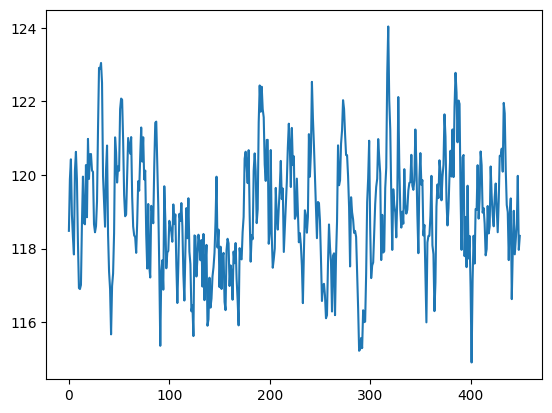

In [16]:
# df1 = csvFile['Births']
df1 = csvFile['Value']
X = df1.values
plt.plot(X)

ADF Statistic: -2.574913
p-value: 0.098294
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
False


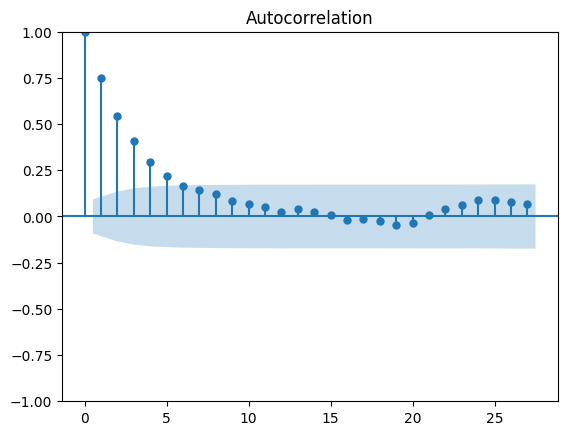

<Figure size 640x480 with 0 Axes>

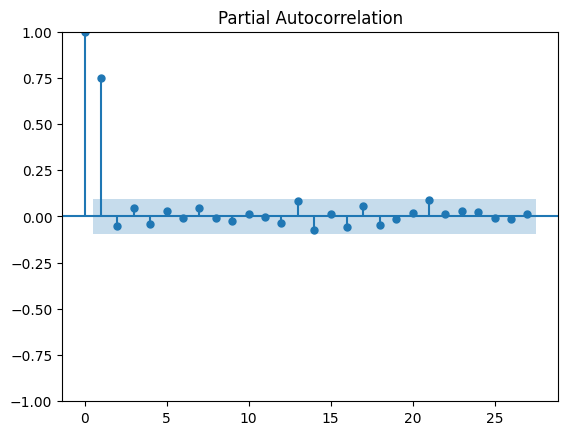

In [17]:
# result = adfuller(X, autolag='aic')
result = adfuller(df1, maxlag=52, autolag=None, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print(is_stationary(df1))
tsplot.plot_acf(X)
plt.figure()
tsplot.plot_pacf(X)    
plt.show()

In [18]:
res = sm.tsa.arma_order_select_ic(df1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

(2, 1)
(1, 0)


In [19]:
trainRatio = .90
thresh = int(len(X)*trainRatio)
print(thresh)
X1 = df1[:thresh]
print(X1)
d = d_param(X1)
res = sm.tsa.arma_order_select_ic(X1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

d = min([2,d])


405
0      118.483849
1      119.888444
2      120.427073
3      118.923218
4      118.318136
          ...    
400    116.943305
401    114.907852
402    117.148115
403    118.349747
404    117.594492
Name: Value, Length: 405, dtype: float64
(2, 1)
(2, 1)


In [20]:
p = 2
q = 1
print(p,d,q)

2 1 1


MSE: 0.8959167316238353
MAPE: 0.006321290005038127


Text(0, 0.5, 'Values')

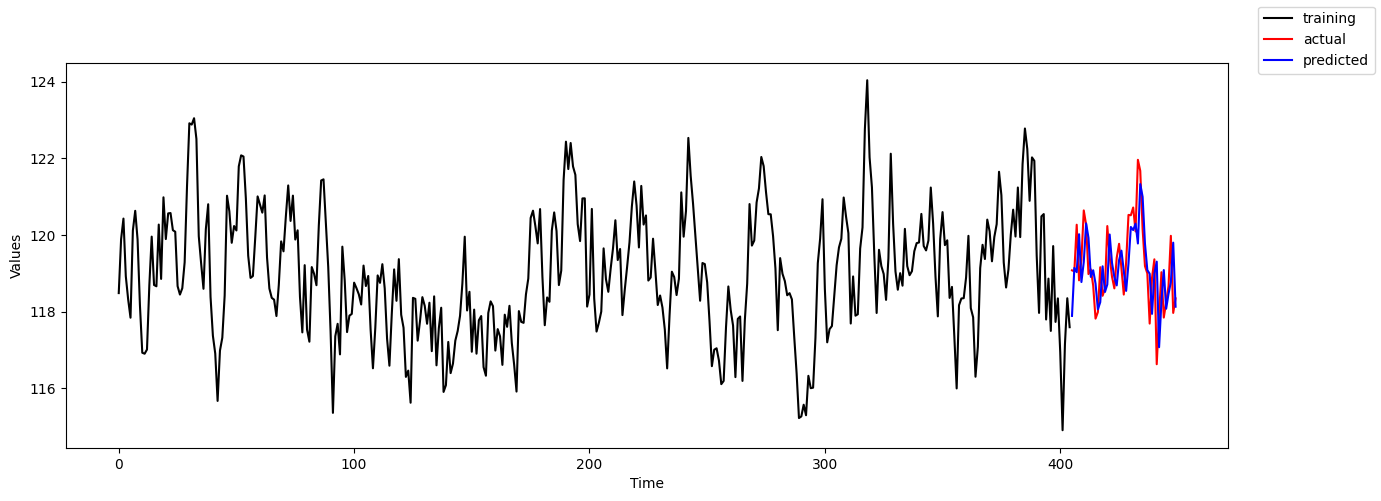

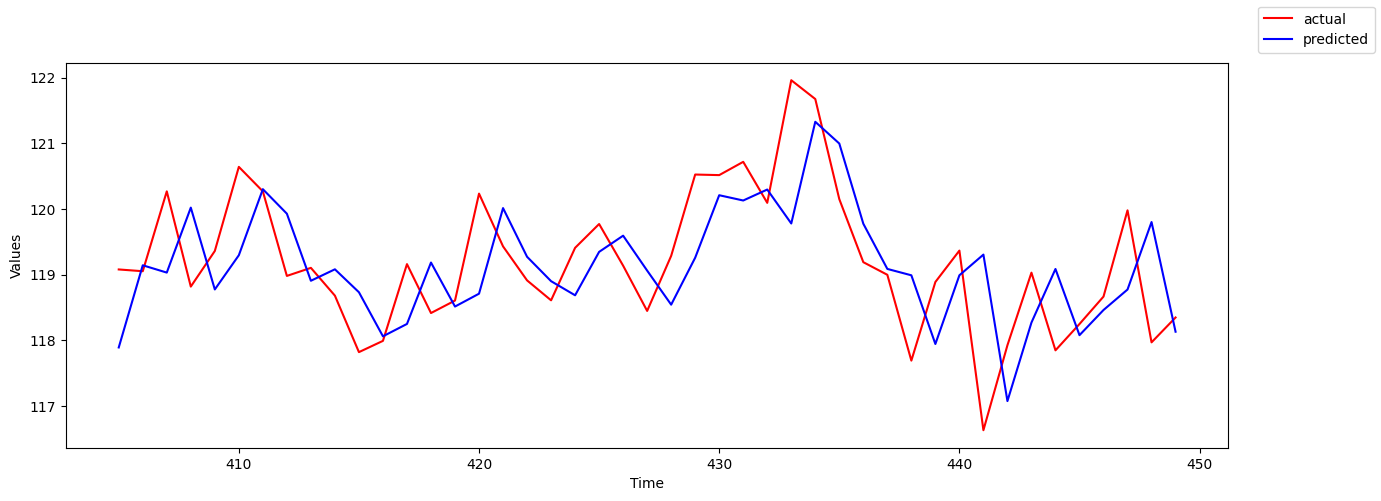

In [23]:

def evaluate_arima_model(X, arima_order, trainRatio):
    # prepare training dataset
    train_size = int(len(X)*trainRatio)
    train, test = X[:train_size], X[train_size:]

    history = [x for x in train]
    

    # make predictions
    predictions = []
    for i in range(0,len(test)):
        history1 = pd.DataFrame(np.asarray(history))

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]

        predictions.append(yhat)
        history.append(test[i])

    mse_error = mean_squared_error(test, predictions)
    mape_error = mean_absolute_percentage_error(test, predictions)

    return mse_error, mape_error, train, test, predictions

arima_order = (p,d,q)


mse_error, mape_error, train, test, predictions = evaluate_arima_model(df1.values, arima_order, trainRatio)
print('MSE:', mse_error)
print('MAPE:', mape_error)


trainRange = np.arange(0,len(train),1)
testRange = np.arange(len(train), len(train) + len(test),1)
# print(trainRange)
# print(testRange)
ax = plt.figure(figsize=(15,5))
plt.plot(trainRange, train, 'k')
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax.legend(['training', 'actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')

ax1 = plt.figure(figsize=(15,5))
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax1.legend(['actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')
